In [49]:
# тип задачи - регрессия(regression)

In [74]:
import pandas as pd # для загрузки датасета(csv)
import numpy as np # численные вычисления и работа с массивами
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV # для разделения данных
from sklearn.ensemble import GradientBoostingRegressor # градиентный бустинг
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder

import matplotlib.pyplot as plt # построение графиков и визуализация
import seaborn as sns # статистическая визуализация

train_new_file_path = r"C:\Practice\data\train_new.csv"
train_df = pd.read_csv(train_new_file_path)

In [75]:
X = train_df.drop(['SalePrice'], axis=1) # признаки
y = train_df['SalePrice'] # целевая переменная

In [76]:
# X - признаки
# y - целевая переменная

X = train_df.drop(['SalePrice'], axis = 1)
y = train_df['SalePrice']

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)

In [78]:
def correct_encoding(X_train, X_test, y_train):
    X_train_encoded = X_train.copy()
    X_test_encoded = X_test.copy()
    
    print("Начало преобразования данных...")
    print(f"Исходные типы данных: {X_train_encoded.dtypes.value_counts()}")
    
    # 1. Порядковые категориальные - Label Encoding
    ordinal_cols = [
        'OverallQual', 'TotRmsAbvGrd', 'ExterQual', 'BsmtQual', 'KitchenQual',
        'GarageQual', 'FireplaceQu', 'HeatingQC', 'BsmtExposure', 'BsmtCond',
        'ExterCond', 'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'GarageFinish'
    ]
    
    ordinal_cols = [col for col in ordinal_cols if col in X_train.columns]
    
    for col in ordinal_cols:
        le = LabelEncoder()
        combined = pd.concat([X_train[col].astype(str), X_test[col].astype(str)])
        le.fit(combined) 
        X_train_encoded[col] = le.transform(X_train_encoded[col].astype(str))
        X_test_encoded[col] = le.transform(X_test_encoded[col].astype(str))
    
    # 2. Neighborhood - особый случай(Frequency Encoding)
    if 'Neighborhood' in X_train.columns and y_train is not None:
        freq_map = X_train['Neighborhood'].value_counts().to_dict()
        X_train_encoded['Neighborhood'] = X_train['Neighborhood'].map(freq_map)
        X_test_encoded['Neighborhood'] = X_test['Neighborhood'].map(freq_map)
    
    # 3. Остальные непорядковые - One-Hot Encoding
    nominal_cols = [
        'MSZoning', 'GarageType', 'Condition1', 'Condition2', 'RoofMatl',
        'Exterior1st', 'Exterior2nd', 'Foundation', 'MiscFeature', 'PoolQC',
        'Heating', 'SaleType', 'SaleCondition'
    ]
    
    nominal_cols = [col for col in nominal_cols if col in X_train.columns]
    
    for col in nominal_cols:
        combined = pd.concat([X_train[[col]], X_test[[col]]])
        combined_encoded = pd.get_dummies(combined, columns=[col], prefix=col, dtype=int)
        train_encoded = combined_encoded.iloc[:len(X_train)]
        test_encoded = combined_encoded.iloc[len(X_train):]
        
        X_train_encoded = X_train_encoded.drop(col, axis=1)
        X_test_encoded = X_test_encoded.drop(col, axis=1)
        
        X_train_encoded = pd.concat([X_train_encoded, train_encoded], axis=1)
        X_test_encoded = pd.concat([X_test_encoded, test_encoded], axis=1)
    
    # 4. Численные признаки - преобразуем в числовой формат
    numeric_cols = [
        'YearBuilt', 'YearRemodAdd', 'GarageArea', '1stFlrSF', 
        'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'Fireplaces', 'FullBath'
    ]
    
    print("Преобразуем численные колонки...")
    for col in numeric_cols:
        if col in X_train_encoded.columns:
            print(f"  Преобразуем {col}...")
            # Преобразуем в числовой формат
            X_train_encoded[col] = pd.to_numeric(X_train_encoded[col], errors='coerce')
            X_test_encoded[col] = pd.to_numeric(X_test_encoded[col], errors='coerce')
            
            # Проверяем и заполняем пропуски
            if X_train_encoded[col].isnull().any():
                median_val = X_train_encoded[col].median()
                X_train_encoded[col] = X_train_encoded[col].fillna(median_val)
                X_test_encoded[col] = X_test_encoded[col].fillna(median_val)
    
    # 5. Преобразуем ВСЕ оставшиеся object колонки
    object_cols = X_train_encoded.select_dtypes(include=['object']).columns
    if len(object_cols) > 0:
        print(f"Преобразуем оставшиеся строковые колонки: {list(object_cols)}")
        
        for col in object_cols:
            # Пробуем преобразовать в числа
            X_train_encoded[col] = pd.to_numeric(X_train_encoded[col], errors='coerce')
            X_test_encoded[col] = pd.to_numeric(X_test_encoded[col], errors='coerce')
            
            # Если не получилось, используем frequency encoding
            if X_train_encoded[col].isnull().any():
                print(f"  Используем frequency encoding для {col}")
                freq_map = X_train_encoded[col].value_counts().to_dict()
                X_train_encoded[col] = X_train_encoded[col].map(freq_map)
                X_test_encoded[col] = X_test_encoded[col].map(freq_map)
    
    # 6. Выравниваем колонки
    X_train_encoded, X_test_encoded = X_train_encoded.align(
        X_test_encoded, join='left', axis=1, fill_value=0
    )
    
    # 7. Гарантируем, что ВСЕ данные числовые
    # Заполняем все оставшиеся NaN
    X_train_encoded = X_train_encoded.fillna(0)
    X_test_encoded = X_test_encoded.fillna(0)
    
    # Преобразуем все в float
    X_train_encoded = X_train_encoded.astype(float)
    X_test_encoded = X_test_encoded.astype(float)
    
    print(f"Итоговые размеры: Train {X_train_encoded.shape}, Test {X_test_encoded.shape}")
    print(f"Типы данных после преобразования: {X_train_encoded.dtypes.value_counts()}")
    print(f"Пропуски в данных: Train - {X_train_encoded.isnull().sum().sum()}, Test - {X_test_encoded.isnull().sum().sum()}")
    
    return X_train_encoded, X_test_encoded


# Посмотрим на типы данных до преобразования
print("=" * 70)
print("ДО преобразования:")
print(X_train.dtypes.value_counts())
print(f"Колонок: {X_train.shape[1]}")

# Применяем преобразование
X_train_encoded, X_test_encoded = correct_encoding(X_train, X_test, y_train)

print("\n" + "=" * 70)
print("ПОСЛЕ преобразования:")
print(X_train_encoded.dtypes.value_counts())
print(f"Колонок: {X_train_encoded.shape[1]}")

# Финальная проверка
print(f"\nФИНАЛЬНАЯ ПРОВЕРКА:")
print(f"✓ Строковых колонок: {(X_train_encoded.dtypes == 'object').sum()}")
print(f"✓ Все данные числовые: {all(X_train_encoded.dtypes != 'object')}")
print(f"✓ Пропусков в тренировочных данных: {X_train_encoded.isnull().sum().sum()}")
print(f"✓ Пропусков в тестовых данных: {X_test_encoded.isnull().sum().sum()}")
print(f"✓ Все данные готовы для обучения модели!")

ДО преобразования:
object    38
Name: count, dtype: int64
Колонок: 38
Начало преобразования данных...
Исходные типы данных: object    38
Name: count, dtype: int64
Преобразуем численные колонки...
  Преобразуем YearBuilt...
  Преобразуем YearRemodAdd...
  Преобразуем GarageArea...
  Преобразуем 1stFlrSF...
  Преобразуем TotalBsmtSF...
  Преобразуем GrLivArea...
  Преобразуем GarageCars...
  Преобразуем Fireplaces...
  Преобразуем FullBath...
Итоговые размеры: Train (2044, 142), Test (877, 142)
Типы данных после преобразования: float64    142
Name: count, dtype: int64
Пропуски в данных: Train - 0, Test - 0

ПОСЛЕ преобразования:
float64    142
Name: count, dtype: int64
Колонок: 142

ФИНАЛЬНАЯ ПРОВЕРКА:
✓ Строковых колонок: 0
✓ Все данные числовые: True
✓ Пропусков в тренировочных данных: 0
✓ Пропусков в тестовых данных: 0
✓ Все данные готовы для обучения модели!


In [79]:
# модель - градиентный бустинг
'''
gb_model = GradientBoostingRegressor(
    # задаем гиперпараметры для модели (гиперпараметры - настройки модели, которые мы задаем до начала обучения модели)
    
    n_estimators = 500, # количество деревьев(оценщиков) в ансамбле
    learning_rate = 0.05, # скорость обучения(5%)
    max_depth = 4, # максимальная глубина деревьев (уровни решения - ограничение сложности)
    random_state = 42, # "заморозка" случайности для экспериментов
    subsample=0.8 # 80% данных использует каждое дерево для обучения
)

gb_model.fit(X_train_encoded, y_train) # обучение модели

# Использует обученную модель для предсказания цен на новых данных
y_gb_test_pred = gb_model.predict(X_test_encoded) # массив с предсказанными ценами домов
y_gb_train_pred = gb_model.predict(X_train_encoded)
'''

#Каждое дерево делает предсказание цены и исправляет ошибки предыдущего.
#Каждое дерево перед приняетием решения может задать 4 вопроса max_depth (ограничение сложности каждого дерева)
#Модель будет последовательно строить 500 простых деревьев, где каждое следующее дерево медленно (5%) исправляет 
#ошибки предыдущих, при этом каждое дерево задает не более 4 вопросов перед принятием решения.


'\ngb_model = GradientBoostingRegressor(\n    # задаем гиперпараметры для модели (гиперпараметры - настройки модели, которые мы задаем до начала обучения модели)\n    \n    n_estimators = 500, # количество деревьев(оценщиков) в ансамбле\n    learning_rate = 0.05, # скорость обучения(5%)\n    max_depth = 4, # максимальная глубина деревьев (уровни решения - ограничение сложности)\n    random_state = 42, # "заморозка" случайности для экспериментов\n    subsample=0.8 # 80% данных использует каждое дерево для обучения\n)\n\ngb_model.fit(X_train_encoded, y_train) # обучение модели\n\n# Использует обученную модель для предсказания цен на новых данных\ny_gb_test_pred = gb_model.predict(X_test_encoded) # массив с предсказанными ценами домов\ny_gb_train_pred = gb_model.predict(X_train_encoded)\n'

In [80]:
'''
gb_train_mae = mean_absolute_error(y_train, y_gb_train_pred)
gb_train_mse = mean_squared_error(y_train, y_gb_train_pred)
gb_train_rmse = np.sqrt(mse) # Root Mean Squared Error(Корень из средней квадратичной ошибки)
gb_train_r_squared = r2_score(y_train, y_gb_train_pred)

print("=== МЕТРИКИ КАЧЕСТВА МОДЕЛИ (для train) ===") # вычисление производительности
print(f"MAE (Mean Absolute Error): {gb_train_mae:,.0f} руб") # MAE = (1/n) * Σ|y_true - y_pred|
print(f"MSE (Mean Squared Error): {gb_train_mse:,.0f}") # MSE = (1/n) * Σ(y_true - y_pred)²
print(f"RMSE (Root Mean Squared Error): {gb_train_rmse:,.0f} руб") # RMSE = √MSE

# Доля дисперсии целевой переменной, объясненная моделью (Коэффициент детерминации)
print(f"R² (R-squared): {gb_train_r_squared:.3f}\n") # R² = 1 - (Σ(y_true - y_pred)² / Σ(y_true - mean(y_true))²)


gb_test_mae = mean_absolute_error(y_test, y_gb_test_pred)
gb_test_mse = mean_squared_error(y_test, y_gb_test_pred)
gb_test_rmse = np.sqrt(mse) # Root Mean Squared Error(Корень из средней квадратичной ошибки)
gb_test_r_squared = r2_score(y_test, y_gb_test_pred)

print("=== МЕТРИКИ КАЧЕСТВА МОДЕЛИ (для test) ===") # вычисление производительности
print(f"MAE (Mean Absolute Error): {gb_test_mae:,.0f} руб") # MAE = (1/n) * Σ|y_true - y_pred|
print(f"MSE (Mean Squared Error): {gb_test_mse:,.0f}") # MSE = (1/n) * Σ(y_true - y_pred)²
print(f"RMSE (Root Mean Squared Error): {gb_test_rmse:,.0f} руб") # RMSE = √MSE

# Доля дисперсии целевой переменной, объясненная моделью (Коэффициент детерминации)
print(f"R² (R-squared): {gb_test_r_squared:.3f}") # R² = 1 - (Σ(y_true - y_pred)² / Σ(y_true - mean(y_true))²)
'''

'\ngb_train_mae = mean_absolute_error(y_train, y_gb_train_pred)\ngb_train_mse = mean_squared_error(y_train, y_gb_train_pred)\ngb_train_rmse = np.sqrt(mse) # Root Mean Squared Error(Корень из средней квадратичной ошибки)\ngb_train_r_squared = r2_score(y_train, y_gb_train_pred)\n\nprint("=== МЕТРИКИ КАЧЕСТВА МОДЕЛИ (для train) ===") # вычисление производительности\nprint(f"MAE (Mean Absolute Error): {gb_train_mae:,.0f} руб") # MAE = (1/n) * Σ|y_true - y_pred|\nprint(f"MSE (Mean Squared Error): {gb_train_mse:,.0f}") # MSE = (1/n) * Σ(y_true - y_pred)²\nprint(f"RMSE (Root Mean Squared Error): {gb_train_rmse:,.0f} руб") # RMSE = √MSE\n\n# Доля дисперсии целевой переменной, объясненная моделью (Коэффициент детерминации)\nprint(f"R² (R-squared): {gb_train_r_squared:.3f}\n") # R² = 1 - (Σ(y_true - y_pred)² / Σ(y_true - mean(y_true))²)\n\n\ngb_test_mae = mean_absolute_error(y_test, y_gb_test_pred)\ngb_test_mse = mean_squared_error(y_test, y_gb_test_pred)\ngb_test_rmse = np.sqrt(mse) # Root Mean

In [81]:
# Анализ для train
# MAE = 4,939 руб: Модель в среднем ошибается на ±4,939 руб рублей
# MSE = 39,620,369: Наказывает большие ошибки сильнее, чем маленькие
# RMSE = 27,244 руб: Стандартное отклонение ошибок модели
# R² (R-squared) = 0.993: 99.3% изменчивости цен объяснено моделью ("Из 100% факторов, влияющих на цену дома, моя модель учитывает 89.4%")

# Анализ для test
# MAE = 16,556 руб: Модель в среднем ошибается на ±16,556 рублей
# MSE = 654,448,609: Наказывает большие ошибки сильнее, чем маленькие
# RMSE = 27,244 руб: Стандартное отклонение ошибок модели
# R² (R-squared) = 0.906: 90.6% изменчивости цен объяснено моделью ("Из 100% факторов, влияющих на цену дома, моя модель учитывает 89.4%")

In [82]:
# определим пространство поиска гиперпараметров с разумными диапазонами значений
'''
search_space = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.03, 0.05, 0.07, 0.1],
    'max_depth': [3, 4, 5, 6],
    'subsample':[0.7, 0.8, 0.9]
}
'''

"\nsearch_space = {\n    'n_estimators': [300, 500, 700],\n    'learning_rate': [0.03, 0.05, 0.07, 0.1],\n    'max_depth': [3, 4, 5, 6],\n    'subsample':[0.7, 0.8, 0.9]\n}\n"

In [83]:
print("=" * 70)
print("ВЫБОР МОДЕЛИ: GradientBoostingRegressor (ЗАДАЧА РЕГРЕССИИ)")
print("=" * 70)

# Сначала проверим и преобразуем целевую переменную
print("Проверяем целевую переменную...")
print(f"Тип y_train: {type(y_train)}")
print(f"Тип данных y_train: {y_train.dtype}")
print(f"Пример значений y_train: {y_train[:5] if hasattr(y_train, '__getitem__') else 'недоступно'}")

# Преобразуем целевую переменную в числовой формат
print("Преобразуем целевую переменную в числовой формат...")

# Если y_train - это Series с строковыми значениями
if hasattr(y_train, 'dtype') and y_train.dtype == 'object':
    y_train = pd.to_numeric(y_train, errors='coerce')
    # Проверяем на пропуски после преобразования
    if y_train.isnull().any():
        print(f"Обнаружены пропуски после преобразования: {y_train.isnull().sum()}")
        # Заполняем пропуски медианой
        y_train = y_train.fillna(y_train.median())

# Если y_test тоже нужно преобразовать
if hasattr(y_test, 'dtype') and y_test.dtype == 'object':
    y_test = pd.to_numeric(y_test, errors='coerce')
    if y_test.isnull().any():
        y_test = y_test.fillna(y_test.median())

print(f"После преобразования - тип y_train: {y_train.dtype}")
print(f"Пример значений y_train: {y_train[:5].values}")

# Обоснование выбора:
# - Задача: ПРЕДСКАЗАНИЕ ЦЕНЫ ДОМА → РЕГРЕССИЯ
# - GradientBoosting: отлично работает с нелинейными зависимостями
# - Хорошая точность на структурированных данных
# - Устойчивость к выбросам

model = GradientBoostingRegressor(random_state=42)
print("Выбрана модель: GradientBoostingRegressor для задачи регрессии")

# Базовая модель с разумными параметрами по умолчанию
base_model = GradientBoostingRegressor(
    n_estimators=500,      # Умеренное количество деревьев для скорости
    random_state=42
)

print("Обучаем базовую модель...")
base_model.fit(X_train_encoded, y_train) # обучение базовой модели

print("\n" + "=" * 70)
print("ПРЕДСКАЗАНИЯ НА ТЕСТОВЫХ ДАННЫХ")
print("=" * 70)

y_pred_base = base_model.predict(X_test_encoded)
print(f"Сделано предсказаний: {len(y_pred_base)}")
print(f"Пример предсказаний: {y_pred_base[:5].astype(int)}")
print(f"Реальные значения: {y_test.values[:5].astype(int)}")

print("\n" + "=" * 70)
print("ОЦЕНКА БАЗОВОЙ МОДЕЛИ (МЕТРИКИ РЕГРЕССИИ)")
print("=" * 70)

def evaluate_regression(y_true, y_pred, model_name="Модель"):
    """Вычисление метрик регрессии"""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    print(f"\n{model_name}:")
    print(f"   MAE (Mean Absolute Error): {mae:,.0f} руб")
    print(f"   MSE (Mean Squared Error): {mse:,.0f}")
    print(f"   RMSE (Root Mean Squared Error): {rmse:,.0f} руб")
    print(f"   R² (R-squared): {r2:.3f}")
    
    return {'MAE': mae, 'MSE': mse, 'RMSE': rmse, 'R2': r2}

# Оценка базовой модели
base_metrics = evaluate_regression(y_test, y_pred_base, "Базовая модель")

print("\n" + "=" * 70)
print("КЛЮЧЕВЫЕ ГИПЕРПАРАМЕТРЫ GradientBoostingRegressor")
print("=" * 70)

key_hyperparameters = {
    'n_estimators': "Количество деревьев в ансамбле",
    'learning_rate': "Скорость обучения (размер шага)",
    'max_depth': "Максимальная глубина деревьев", 
    'subsample': "Доля данных для каждого дерева"
}

print("Ключевые гиперпараметры для настройки:")
for (param, description) in key_hyperparameters.items():
    print(f"    {param}: {description}")

print("\n" + "=" * 70)
print(" ПРОСТРАНСТВО ПОИСКА ГИПЕРПАРАМЕТРОВ")
print("=" * 70)

# Разумные диапазоны значений на основе практического опыта
param_distributions = {
    'n_estimators': [100, 200, 300, 500],      # От простого к сложному
    'learning_rate': [0.01, 0.05, 0.1],  # Проверенные значения
    'max_depth': [3, 4, 5, 6],                 # Оптимальная глубина
    'subsample': [0.7, 0.8, 0.9]         # Стабильность предсказаний
}

print("Разумные диапазоны поиска:")
for param, values in param_distributions.items():
    print(f"   {param}: {values}")

print("\n" + "=" * 70)
print("КРОСС-ВАЛИДАЦИЯ ДЛЯ НАДЕЖНОЙ ОЦЕНКИ")
print("=" * 70)

def cross_validation_evaluation(model, X, y, model_name="Модель"):
    """Надежная оценка с кросс-валидацией"""
    print(f"\nКросс-валидация {model_name}:")
    
    # 5-кратная кросс-валидация с R²
    cv_scores = cross_val_score(model, X, y, cv=5, scoring='r2')
    
    print(f"   R² на 5 фолдах: {cv_scores.round(3)}")
    print(f"   Средний R²: {cv_scores.mean():.3f} ± {cv_scores.std():.3f}")
    
    return cv_scores

# Оценка базовой модели с кросс-валидацией
cv_scores_base = cross_validation_evaluation(base_model, X_train_encoded, y_train, "базовой модели")

print("\n" + "=" * 70)
print("ПОИСК ЛУЧШИХ ГИПЕРПАРАМЕТРОВ")
print("=" * 70)

from sklearn.model_selection import GridSearchCV

# Оптимальная сетка параметров для GridSearch
param_grid = {
    'n_estimators': [300, 500, 700],
    'learning_rate': [0.05, 0.1, 0.15],
    'max_depth': [3, 4, 5],
    'subsample': [0.7, 0.8, 0.9]
}

grid_search = GridSearchCV(
    estimator=GradientBoostingRegressor(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='neg_mean_squared_error',
    n_jobs=-1,
    verbose=1
)

print("Запускаем поиск лучших параметров...")
grid_search.fit(X_train_encoded, y_train)

print(f"Лучшие параметры: {grid_search.best_params_}")
print(f"Лучшая оценка (MSE): {-grid_search.best_score_:,.2f}")

print("\n" + "=" * 70)
print("ФИНАЛЬНАЯ МОДЕЛЬ С ОПТИМАЛЬНЫМИ ПАРАМЕТРАМИ")
print("=" * 70)

# Финальная модель с лучшими параметрами
final_model = grid_search.best_estimator_
final_model.fit(X_train_encoded, y_train)

# Предсказания и оценка
y_pred_final = final_model.predict(X_test_encoded)
final_metrics = evaluate_regression(y_test, y_pred_final, "Финальная модель")

# Кросс-валидация финальной модели
cv_scores_final = cross_validation_evaluation(final_model, X_train_encoded, y_train, "финальной модели")

print("\n" + "=" * 70)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("=" * 70)

print("Метрика       | Базовая модель | Финальная модель | Улучшение")
print("------------------------------------------------------------")
print(f"MAE           | {base_metrics['MAE']:,.0f} руб | {final_metrics['MAE']:,.0f} руб | {base_metrics['MAE'] - final_metrics['MAE']:,.0f} руб")
print(f"RMSE          | {base_metrics['RMSE']:,.0f} руб | {final_metrics['RMSE']:,.0f} руб | {base_metrics['RMSE'] - final_metrics['RMSE']:,.0f} руб")
print(f"R²            | {base_metrics['R2']:.3f}       | {final_metrics['R2']:.3f}       | {final_metrics['R2'] - base_metrics['R2']:+.3f}")
print(f"R² (CV)       | {cv_scores_base.mean():.3f}       | {cv_scores_final.mean():.3f}       | {cv_scores_final.mean() - cv_scores_base.mean():+.3f}")

ВЫБОР МОДЕЛИ: GradientBoostingRegressor (ЗАДАЧА РЕГРЕССИИ)
Проверяем целевую переменную...
Тип y_train: <class 'pandas.core.series.Series'>
Тип данных y_train: object
Пример значений y_train: 449     120000
1334    125000
2371    154300
1073    159500
84      168500
Name: SalePrice, dtype: object
Преобразуем целевую переменную в числовой формат...
Обнаружены пропуски после преобразования: 1
После преобразования - тип y_train: float64
Пример значений y_train: [120000. 125000. 154300. 159500. 168500.]
Выбрана модель: GradientBoostingRegressor для задачи регрессии
Обучаем базовую модель...

ПРЕДСКАЗАНИЯ НА ТЕСТОВЫХ ДАННЫХ
Сделано предсказаний: 877
Пример предсказаний: [199197 212030 175469 288262 159521]
Реальные значения: [179665 190000 205000 260000 174000]

ОЦЕНКА БАЗОВОЙ МОДЕЛИ (МЕТРИКИ РЕГРЕССИИ)

Базовая модель:
   MAE (Mean Absolute Error): 10,347 руб
   MSE (Mean Squared Error): 251,271,923
   RMSE (Root Mean Squared Error): 15,852 руб
   R² (R-squared): 0.961

КЛЮЧЕВЫЕ ГИПЕРПАРАМ

In [89]:
test_file_path = r"C:\Practice\data\test.csv"
test_df = pd.read_csv(test_file_path)

In [90]:
test_df_filled = test_df.fillna(test_df.mean(numeric_only = True)).fillna("Unknown") #  заполняем пропуски

In [91]:
test_df_filled.isnull().any().any() # пропусков нет

np.False_

In [92]:
print(test_df_filled.duplicated().sum()) # дубликатов нет

0


Пропусков нет: True
Дубликатов нет: True
Доступно признаков в тестовых данных: 38 из 38
Начало преобразования данных...
Исходные типы данных: object    38
Name: count, dtype: int64
Преобразуем численные колонки...
  Преобразуем YearBuilt...
  Преобразуем YearRemodAdd...
  Преобразуем GarageArea...
  Преобразуем 1stFlrSF...
  Преобразуем TotalBsmtSF...
  Преобразуем GrLivArea...
  Преобразуем GarageCars...
  Преобразуем Fireplaces...
  Преобразуем FullBath...
Итоговые размеры: Train (2044, 144), Test (1459, 144)
Типы данных после преобразования: float64    144
Name: count, dtype: int64
Пропуски в данных: Train - 0, Test - 0
Размерность тестовых данных после кодирования: (1459, 144)
Добавлена отсутствующая колонка: RoofMatl_ClyTile
Добавлена отсутствующая колонка: Exterior1st_ImStucc
Финальная размерность тестовых данных: (1459, 142)
Создаем submission файл...
Submission файл сохранен как: submission.csv

Статистика предсказаний:
Количество предсказаний: 1459
Минимальная цена: $36,003
Ма

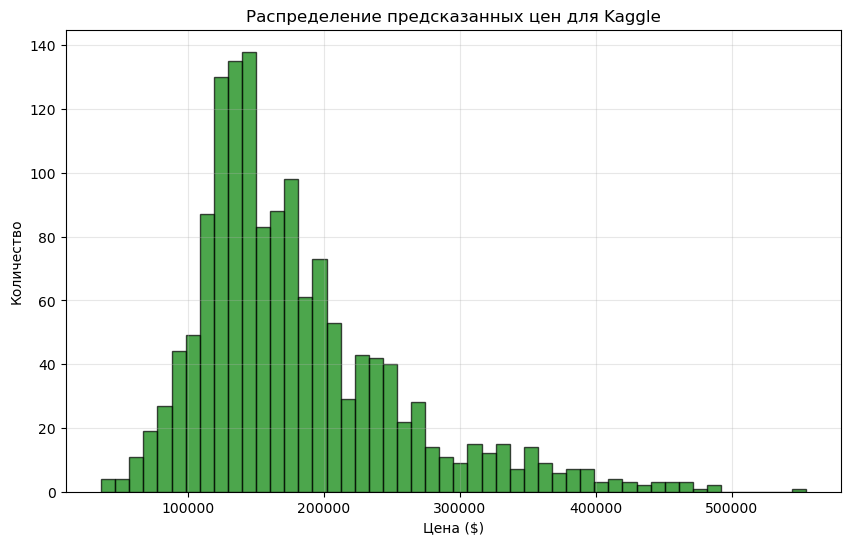

График распределения сохранен как 'kaggle_predictions_distribution.png'

Финальная проверка submission файла:
Размер: (1459, 2)
Колонки: ['Id', 'SalePrice']
Пропуски: 0
Отрицательные цены: 0
Диапазон цен: $36,003 - $554,563


In [93]:
test_file_path = r"C:\Practice\data\test.csv"
test_df = pd.read_csv(test_file_path)

test_df_filled = test_df.fillna(test_df.mean(numeric_only=True)).fillna("Unknown") # заполняем пропуски
print(f"Пропусков нет: {not test_df_filled.isnull().any().any()}") # пропусков нет
print(f"Дубликатов нет: {test_df_filled.duplicated().sum() == 0}") # дубликатов нет

# Определяем важные признаки из анализа
important_numeric_features = [
    'OverallQual', 'YearBuilt', 'YearRemodAdd', 'GarageArea', 
    '1stFlrSF', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 
    'Fireplaces', 'TotRmsAbvGrd', 'FullBath'
]

important_categorical_features = [
    'MSZoning', 'GarageType', 'Neighborhood', 'Condition1', 
    'Condition2', 'ExterQual', 'BsmtQual', 'KitchenQual', 
    'GarageQual', 'GarageFinish', 'SaleType', 'SaleCondition', 
    'FireplaceQu', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 
    'Foundation', 'MiscFeature', 'PoolQC', 'Electrical', 
    'HeatingQC', 'Heating', 'BsmtExposure', 'BsmtCond', 
    'ExterCond', 'BsmtFinType1', 'BsmtFinType2'
]

# Объединяем все важные признаки
all_important_features = important_numeric_features + important_categorical_features

# Проверяем доступность признаков в тестовом датасете
available_features = [f for f in all_important_features if f in test_df_filled.columns]
print(f"Доступно признаков в тестовых данных: {len(available_features)} из {len(all_important_features)}")

# СОЗДАЕМ ТЕСТОВЫЙ ДАТАСЕТ ТОЛЬКО С ВАЖНЫМИ ПРИЗНАКАМИ
test_df_important = test_df_filled[available_features].copy()

# Используем ту же функцию correct_encoding, но только для тестовых данных
# Для этого создаем временные тренировочные данные с теми же признаками
X_temp_train = X_train[available_features].copy()

# Применяем кодирование
_, X_test_encoded_for_kaggle = correct_encoding(
    X_temp_train,           # тренировочные данные с теми же признаками
    test_df_important,      # тестовые данные для кодирования
    y_train                 # целевая переменная для frequency encoding
)

print(f"Размерность тестовых данных после кодирования: {X_test_encoded_for_kaggle.shape}")

# ВЫРАВНИВАЕМ КОЛОНКИ С ТРЕНИРОВОЧНЫМИ ДАННЫМИ

# Добавляем отсутствующие колонки
for col in X_train_encoded.columns:
    if col not in X_test_encoded_for_kaggle.columns:
        X_test_encoded_for_kaggle[col] = 0
        print(f"Добавлена отсутствующая колонка: {col}")

# Убираем лишние колонки и сохраняем порядок
X_test_encoded_for_kaggle = X_test_encoded_for_kaggle[X_train_encoded.columns]

print(f"Финальная размерность тестовых данных: {X_test_encoded_for_kaggle.shape}")

kaggle_predictions = final_model.predict(X_test_encoded_for_kaggle)

# Создание submission файла
print("Создаем submission файл...")
submission = pd.DataFrame({
    'Id': test_df['Id'],
    'SalePrice': kaggle_predictions
})

# Проверяем на отрицательные значения
if (submission['SalePrice'] <= 0).any():
    print("Обнаружены отрицательные цены, исправляем...")
    submission['SalePrice'] = submission['SalePrice'].clip(lower=1)

# Сохранение submission файла
submission_file = 'submission.csv'
submission.to_csv(submission_file, index=False)
print(f"Submission файл сохранен как: {submission_file}")

# Статистика предсказаний
print(f"\nСтатистика предсказаний:")
print(f"Количество предсказаний: {len(kaggle_predictions)}")
print(f"Минимальная цена: ${kaggle_predictions.min():,.0f}")
print(f"Максимальная цена: ${kaggle_predictions.max():,.0f}") 
print(f"Средняя цена: ${kaggle_predictions.mean():,.0f}")
print(f"Медианная цена: ${np.median(kaggle_predictions):,.0f}")

# Визуализация распределения цен
plt.figure(figsize=(10, 6))
plt.hist(kaggle_predictions, bins=50, alpha=0.7, color='green', edgecolor='black')
plt.title('Распределение предсказанных цен для Kaggle')
plt.xlabel('Цена ($)')
plt.ylabel('Количество')
plt.grid(True, alpha=0.3)
plt.savefig('kaggle_predictions_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"График распределения сохранен как 'kaggle_predictions_distribution.png'")

# Финальная проверка файла
print(f"\nФинальная проверка submission файла:")
submission_check = pd.read_csv(submission_file)
print(f"Размер: {submission_check.shape}")
print(f"Колонки: {list(submission_check.columns)}")
print(f"Пропуски: {submission_check.isnull().sum().sum()}")
print(f"Отрицательные цены: {(submission_check['SalePrice'] <= 0).sum()}")
print(f"Диапазон цен: ${submission_check['SalePrice'].min():,.0f} - ${submission_check['SalePrice'].max():,.0f}")
